In [35]:
import sys, os

import numpy, pandas
import tensorboard
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import glob


In [ ]:
sparse_directory = "/Users/corey.adams/Remote/Cooley/DeepLearnPhysics/PointNetEventID/comparison_logs/2d/sparse/"
dense_directory = "/Users/corey.adams/Remote/Cooley/DeepLearnPhysics/PointNetEventID/comparison_logs/2d/dense/"
test_dir = glob.glob(dense_directory + "*")[6]

In [26]:
def tabulate_events(dpath):
    ''' Go into a tensorboard even log and scrape up all of the scalars, return the output in a usable way
    '''
    summary_iterators = [EventAccumulator(os.path.join(dpath, dname)).Reload() for dname in os.listdir(dpath)]

    for summary_iterator in summary_iterators:
        if summary_iterator.Tags()['scalars'] == []:
            continue
        else:
            break

    tags = summary_iterator.Tags()['scalars']

    out = {}
    steps = []

    for tag in tags:
        events = summary_iterator.Scalars(tag)
        out[tag] = [e.value for e in events]
        if steps == []:
            steps = [e.step for e in events]
        else:
            assert steps == [e.step for e in events]

    return out, steps

In [36]:
def analyze_events(output):
    # This function receives the tabulated events from tensorboard and does some basic analysis on them:
    summary = {
        key : numpy.mean(output[key][1:])
        for key in output
    }
    return summary

In [33]:
output, steps = tabulate_events(test_dir)
print(output.keys())

dict_keys(['loss', 'acc/label_cpi', 'step_time', 'acc/label_prot', 'global_step_per_sec', 'acc/label_neut', 'io_fetch_time', 'acc/label_npi', 'images_per_second', 'learning_rate'])


In [37]:
analyzed = analyze_events(output)

In [38]:
print(analyzed)

{'loss': 3.4659100770950317, 'acc/label_cpi': 0.645833358168602, 'step_time': 0.05389375053346157, 'acc/label_prot': 0.3750000111758709, 'global_step_per_sec': 0.05622651241719723, 'acc/label_neut': 0.3750000149011612, 'io_fetch_time': 0.013420499861240387, 'acc/label_npi': 0.7083333432674408, 'images_per_second': 1.3494363129138947, 'learning_rate': 9.999999747378752e-05}


In [76]:
df = pandas.DataFrame(columns=[
    'images_per_second', 
    'batch_size',
    'sparse',
    'step_time',
    'distributed',
    'io_fetch_time',
])

In [80]:
for i, directory in enumerate(glob.glob(sparse_directory + "*")):
    name = os.path.basename(directory)
#     print(name)
    distributed = "_d" in name
    batch_size = int("".join([x if x.isdigit() else "" for x in name ]))
#     print(distributed)
#     print(batch_size)    
    output, steps = tabulate_events(directory)
    ana = analyze_events(output)
    for key in ana:
        if key in df.columns:
            df.loc[i, key]  = ana[key] 
    df.loc[i, 'batch_size'] = batch_size
    df.loc[i, 'distributed'] = distributed
    df.loc[i, 'sparse'] = True
offset = i

for i, directory in enumerate(glob.glob(dense_directory + "*")):
    name = os.path.basename(directory)
#     print(name)
    distributed = "_d" in name
    batch_size = int("".join([x if x.isdigit() else "" for x in name ]))
#     print(distributed)
#     print(batch_size)    
    output, steps = tabulate_events(directory)
    ana = analyze_events(output)
    for key in ana:
        if key in df.columns:
            df.loc[i+offset, key]  = ana[key] 
    df.loc[i+offset, 'batch_size'] = batch_size
    df.loc[i+offset, 'distributed'] = distributed
    df.loc[i+offset, 'sparse'] = False


In [172]:
df.query("sparse==True ")

,images_per_second,batch_size,sparse,step_time,distributed,io_fetch_time
0,1.99663,1,True,0.0234417,False,0.127427
1,15.4693,12,True,0.0235757,False,0.153673
2,39.6507,192,True,0.0237003,False,0.270754
3,66.7015,192,True,0.055719,True,0.0407693
4,3.77609,2,True,0.0234562,False,0.137665
5,67.2362,2048,True,0.0543938,True,0.467043
6,23.1418,24,True,0.024048,False,0.128427
7,25.226,24,True,0.057378,True,0.00527925
8,5.96252,4,True,0.0249767,False,0.122124
9,33.0925,48,True,0.025407,False,0.148857


In [79]:
from matplotlib import pyplot as plt

In [110]:
# Make a histogram of images per second for all comparisons possible batch sizes

batch_size = [1, 2, 4, 12]

sparse_ips = []
dense_ips  = []

for l in batch_size:
    sparse_ips.append(df.query("batch_size=={} & distributed==False & sparse==True".format(l))['images_per_second'].values[0])
    dense_ips.append(df.query("batch_size=={} & distributed==False & sparse==False".format(l))['images_per_second'].values[0])

In [113]:
print(sparse_ips)
print(dense_ips)

[1.996631771326065, 3.776085078716278, 5.962520360946655, 15.469348669052124]
[0.10603292658925056, 0.20104912668466568, 0.34444449096918106, 0.6778225004673004]


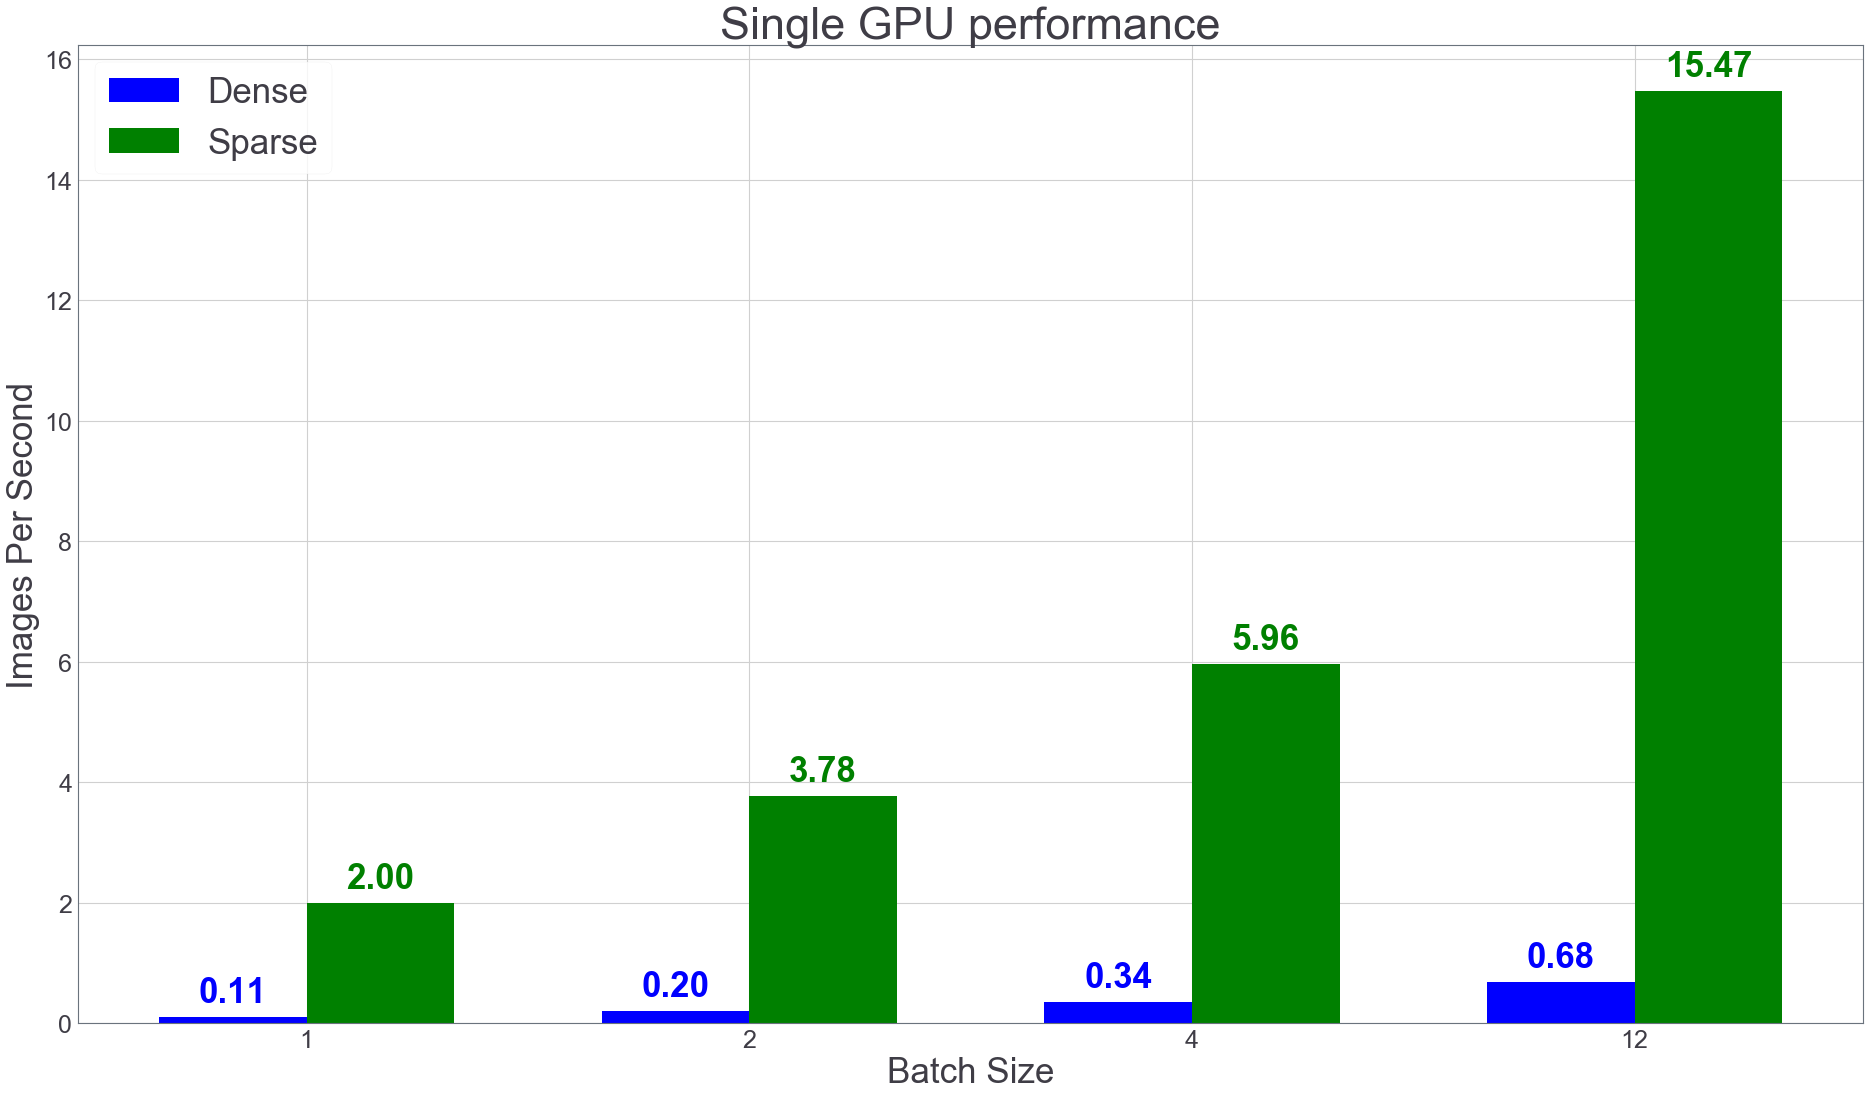

In [171]:
# Bar chart time:

width=1./4.
index = numpy.arange(0, len(sparse_ips), 1) * 3.*width

fig = plt.figure(figsize=(32, 18))

plt.bar(index-width*0.5, dense_ips, width=width,label="Dense",
       color='blue')
plt.bar(index+width*0.5, sparse_ips, width=width,label="Sparse",
       color='green')

ax = plt.gca()

for i, v in enumerate(dense_ips):
    ax.text(index[i]-width*0.5, 0.25 + v, 
            "{0:.2f}".format(v), 
            color      = 'blue', 
            fontweight = 'bold', 
            fontsize   = 35, 
            horizontalalignment  = 'center'
           )
for i, v in enumerate(sparse_ips):
    ax.text(index[i]+width*0.5, 0.25 + v, 
            "{0:.2f}".format(v), 
            color      = 'green', 
            fontweight = 'bold', 
            fontsize   = 35, 
            horizontalalignment  = 'center'
           )
    
    
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
# ax.set_yscale('log')
    
plt.xlabel("Batch Size", fontsize=35)
plt.ylabel("Images Per Second", fontsize=35)

plt.xticks(index, batch_size)
plt.legend(fontsize=35)
plt.title("Single GPU performance", fontsize=45)

ax.set_axisbelow(True)
plt.grid(True)

plt.show()

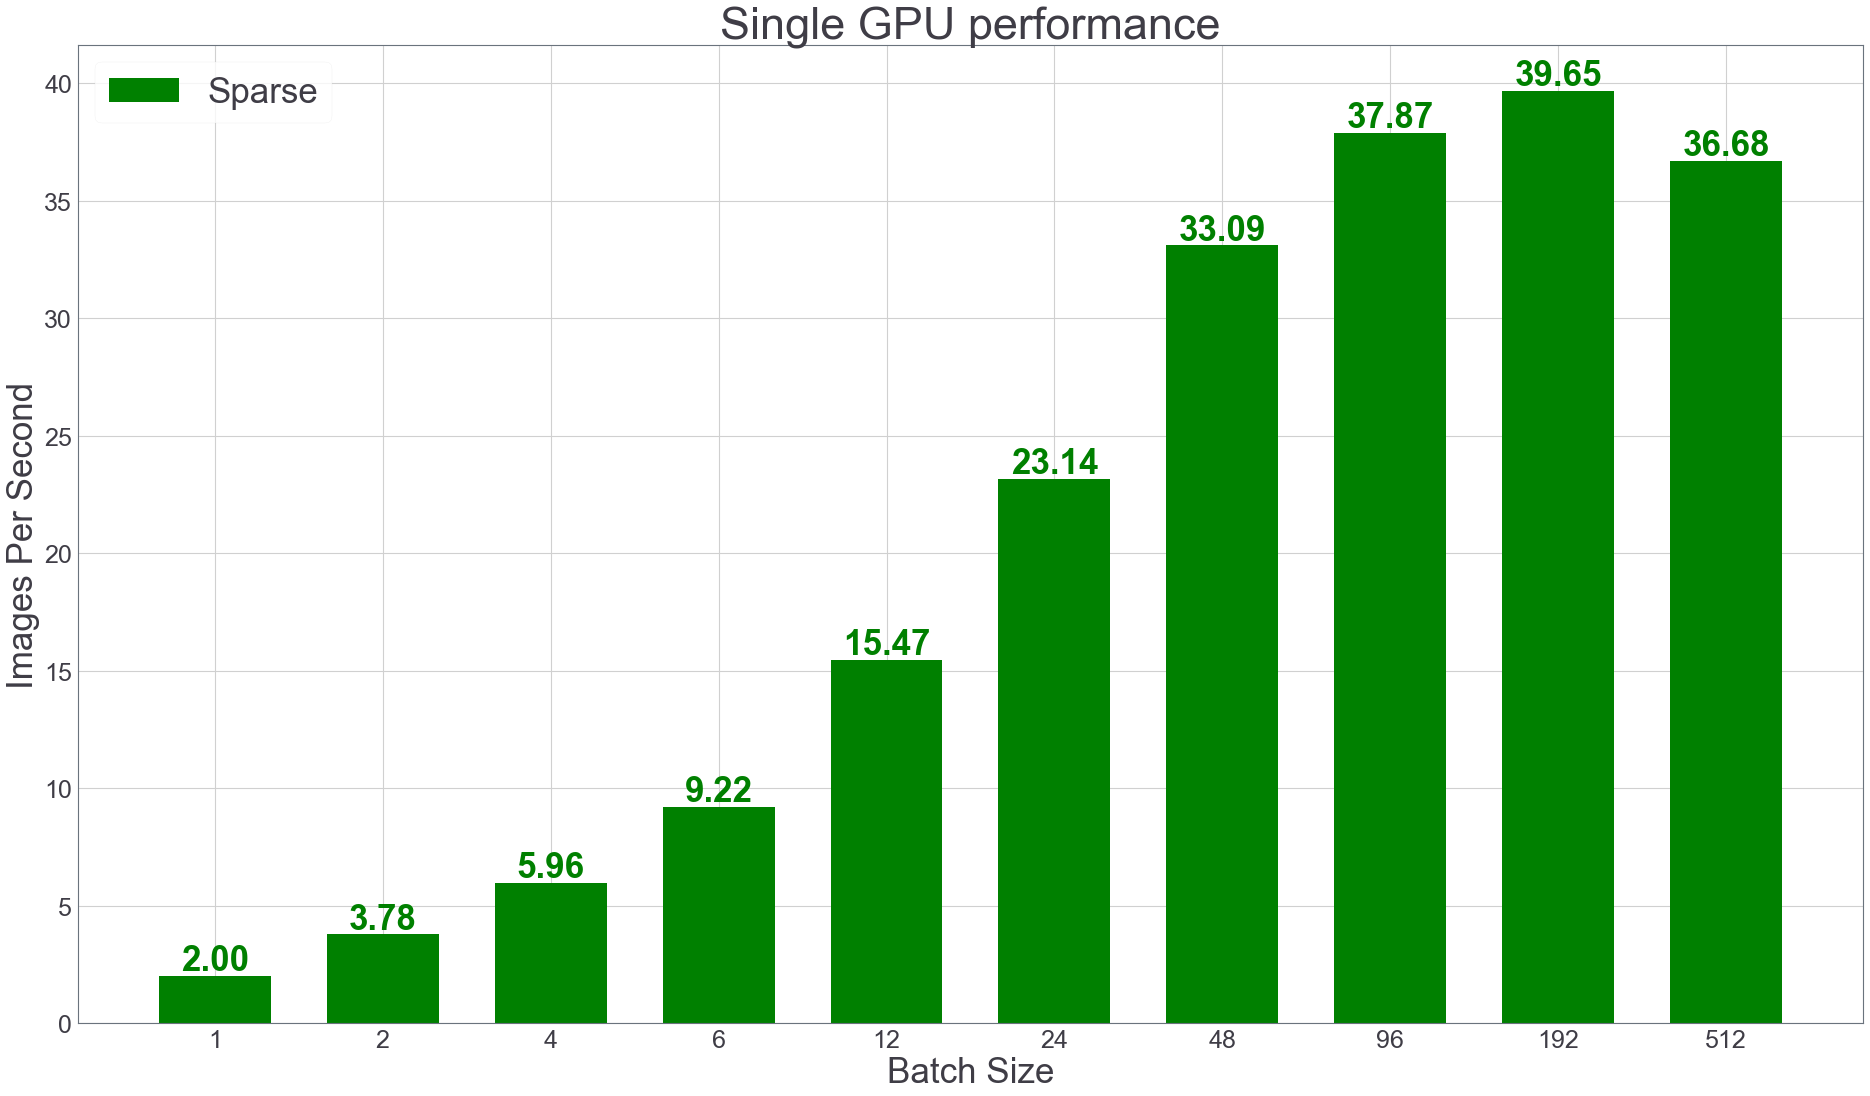

In [167]:
sparse_1gpu_df = df.query("sparse==True & distributed == False").sort_values(by='batch_size')

labels = sparse_1gpu_df['batch_size']
values = sparse_1gpu_df['images_per_second']

width=1.
spacing = 1.5
index = numpy.arange(0, len(labels), 1) * spacing*width

fig = plt.figure(figsize=(32, 18))


plt.bar(index, values, width=width,label="Sparse",
       color='green')

ax = plt.gca()

for i, v in enumerate(values):
    ax.text(index[i], 0.25 + v, 
            "{0:.2f}".format(v), 
            color      = 'green', 
            fontweight = 'bold', 
            fontsize   = 35, 
            horizontalalignment  = 'center'
           )
    
    
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
# ax.set_yscale('log')
    
plt.xlabel("Batch Size", fontsize=35)
plt.ylabel("Images Per Second", fontsize=35)

plt.xticks(index, labels)
plt.legend(fontsize=35)
plt.title("Single GPU performance", fontsize=45)
ax.set_axisbelow(True)
plt.grid(True)
plt.show()


# Pixel Occupancy

In [265]:
#Read in the file of pixel counts:
pixel_counts_2d = numpy.load("/Users/corey.adams/DeepLearnPhysics/SparseEventID/analysis/2d_counts.npz.npy").flatten()
pixel_counts_3d = numpy.load("/Users/corey.adams/DeepLearnPhysics/SparseEventID/analysis/3d_counts.npz.npy")

In [275]:
print(numpy.max(pixel_counts_3d))
print(numpy.max(pixel_counts_3d) / 512**3)

12874.0
9.591877460479736e-05


In [267]:
scaled_counts_2d = 100*pixel_counts_2d / (512**2)
scaled_counts_3d = 100*pixel_counts_3d / (512**3)

In [268]:
scaled_counts_2d[0:10]
scaled_counts_3d[0:10]

array([[0.00011623],
       [0.0003621 ],
       [0.00015497],
       [0.0013195 ],
       [0.00064895],
       [0.00214055],
       [0.00047982],
       [0.00056252],
       [0.00031739],
       [0.00039339]])

In [269]:
bins_2d = numpy.arange(0, 3, 0.05)
bins_3d = numpy.arange(0, .01, 0.0001)
histogram2d, bin_edges = numpy.histogram(scaled_counts_2d, bins=bins_2d)
histogram3d, bin_edges = numpy.histogram(scaled_counts_3d, bins=bins_3d)

histogram2d = histogram2d * (100./numpy.sum(histogram2d))
histogram3d = histogram3d * (100./numpy.sum(histogram3d))


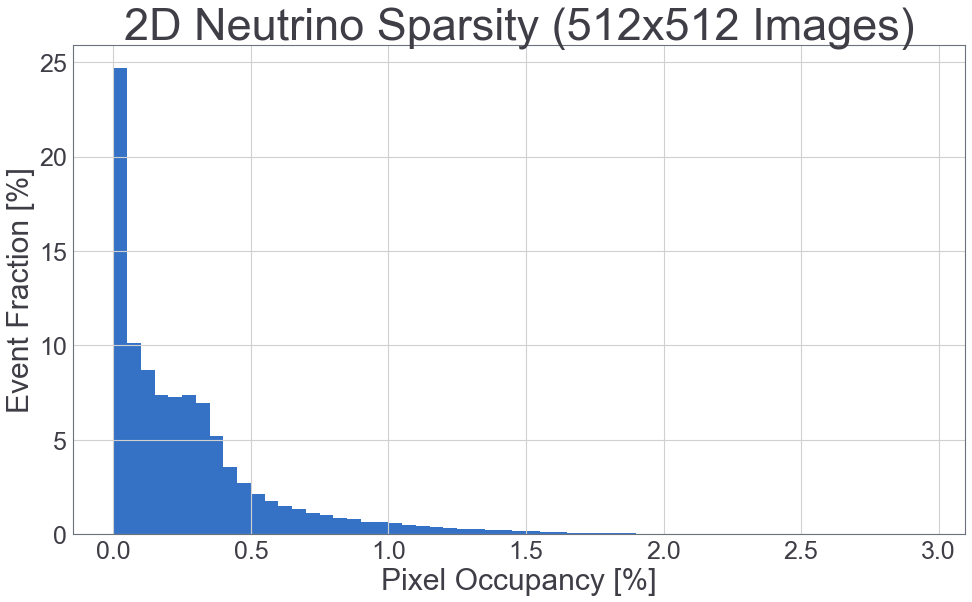

In [279]:

fig = plt.figure(figsize=(16, 9))

bin_centers = 0.5*(bins_2d[1:] + bins_2d[:-1])
bin_width = bins_2d[1:] - bins_2d[:-1]

plt.bar(bin_centers, histogram2d, width=bin_width)

ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
plt.xlabel("Pixel Occupancy [%]",fontsize=30)
plt.ylabel("Event Fraction [%]",fontsize=30)
plt.title("2D Neutrino Sparsity (512x512 Images)", fontsize=45)    
plt.show()



In [271]:
0.01 * 512**2

2621.44

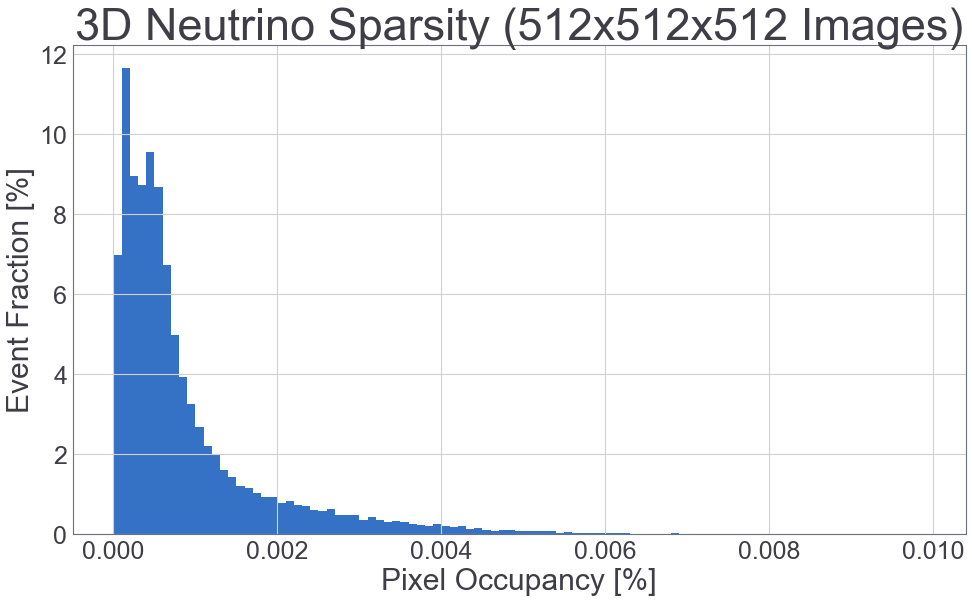

In [278]:
fig = plt.figure(figsize=(16, 9))

bin_centers = 0.5*(bins_3d[1:] + bins_3d[:-1])
bin_width = bins_3d[1:] - bins_3d[:-1]

plt.bar(bin_centers, histogram3d, width=bin_width)

ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
plt.xlabel("Pixel Occupancy [%]",fontsize=30)
plt.ylabel("Event Fraction [%]",fontsize=30)
plt.title("3D Neutrino Sparsity (512x512x512 Images)", fontsize=45)    
plt.show()

In [277]:
0.00008 * (512**3)

10737.41824

In [263]:
512**3

134217728

# Loss during training

In [336]:
# Open the 4 csv files:
loss_2d = pandas.read_csv("run_2d_sparse_32nodes_bs2048_nf32-tag-loss.csv")
loss_2d_test = pandas.read_csv("run_2d_sparse_32nodes_bs2048_nf32_test-tag-loss.csv")
loss_3d = pandas.read_csv("run_3d_sparse_32nodes_bs2048_nf32-tag-loss.csv")
loss_3d_test = pandas.read_csv("run_3d_sparse_32nodes_bs2048_nf32_test-tag-loss.csv")

loss_2d['Epoch'] = loss_2d['Step']*2048 / 90000.
loss_2d_test['Epoch'] = loss_2d_test['Step']*2048 / 90000.
loss_3d['Epoch'] = loss_3d['Step']*2048 / 90000.
loss_3d_test['Epoch'] = loss_3d_test['Step']*2048 / 90000.

loss_2d_test['Value'][0] = 3.6

loss_2d['Time'] = (loss_2d['Wall time'] - loss_2d['Wall time'][0]) / 3600.
loss_2d_test['Time'] = (loss_2d_test['Wall time'] - loss_2d_test['Wall time'][0]) / 3600.
loss_3d['Time'] = (loss_3d['Wall time'] - loss_3d['Wall time'][0]) / 3600.
loss_3d_test['Time'] = (loss_3d_test['Wall time'] - loss_3d_test['Wall time'][0]) / 3600.





/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [339]:
loss_2d_test['Time']

0      0.000000
1      0.017328
2      0.034160
3      0.049218
4      0.064911
5      0.079783
6      0.094847
7      0.108979
8      0.123685
9      0.138793
10     0.154352
11     0.169407
12     0.184196
13     0.199461
14     0.214571
15     0.229867
16     0.244807
17     0.260051
18     0.275149
19     0.290319
20     0.306441
21     0.321233
22     0.336314
23     0.351077
24     0.366268
25     0.381116
26     0.396402
27     0.410603
28     0.425725
29     0.440249
         ...   
234    3.541358
235    3.556714
236    3.571622
237    3.586066
238    3.601230
239    3.616046
240    3.631862
241    3.646612
242    3.661766
243    3.676787
244    3.692131
245    3.707292
246    3.722486
247    3.737721
248    3.752850
249    3.767781
250    3.782914
251    3.797944
252    3.812926
253    3.828087
254    3.843509
255    3.858834
256    3.874096
257    3.889283
258    3.904501
259    3.919391
260    3.934636
261    3.950003
262    3.964751
263    3.979939
Name: Time, Length: 264,

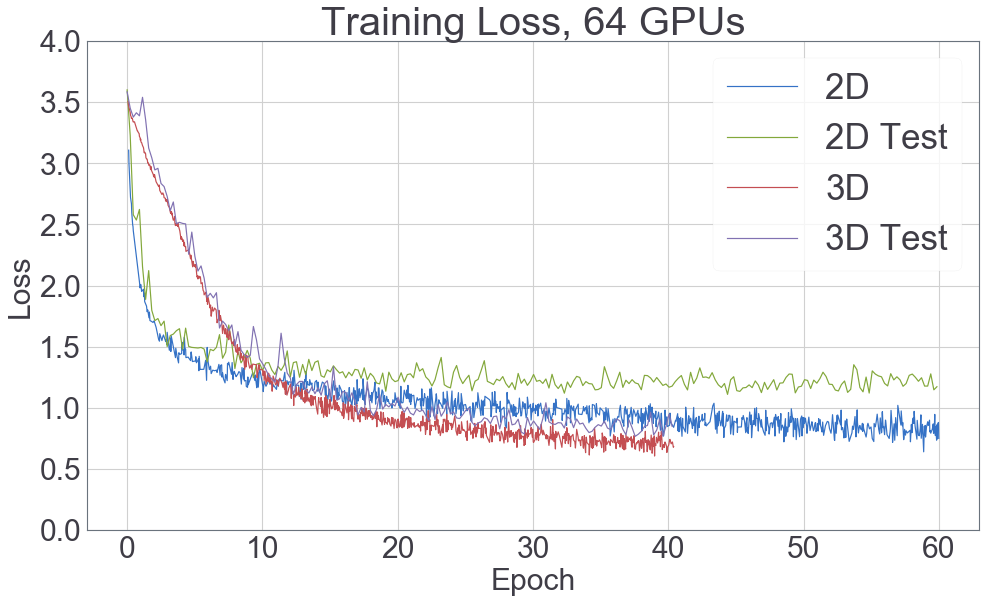

In [342]:
fig = plt.figure(figsize=(16, 9))

plt.plot(loss_2d['Epoch'], loss_2d['Value'], label="2D")
plt.plot(loss_2d_test['Epoch'], loss_2d_test['Value'], label="2D Test")
plt.plot(loss_3d['Epoch'], loss_3d['Value'], label="3D")
plt.plot(loss_3d_test['Epoch'], loss_3d_test['Value'], label="3D Test")

ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
# ax.set_yscale('log')

plt.ylabel("Loss",fontsize=30)
plt.xlabel("Epoch",fontsize=30)
plt.legend(fontsize=35)
plt.title("Training Loss, 64 GPUs", fontsize=40)


plt.ylim([0, 4])
plt.show()

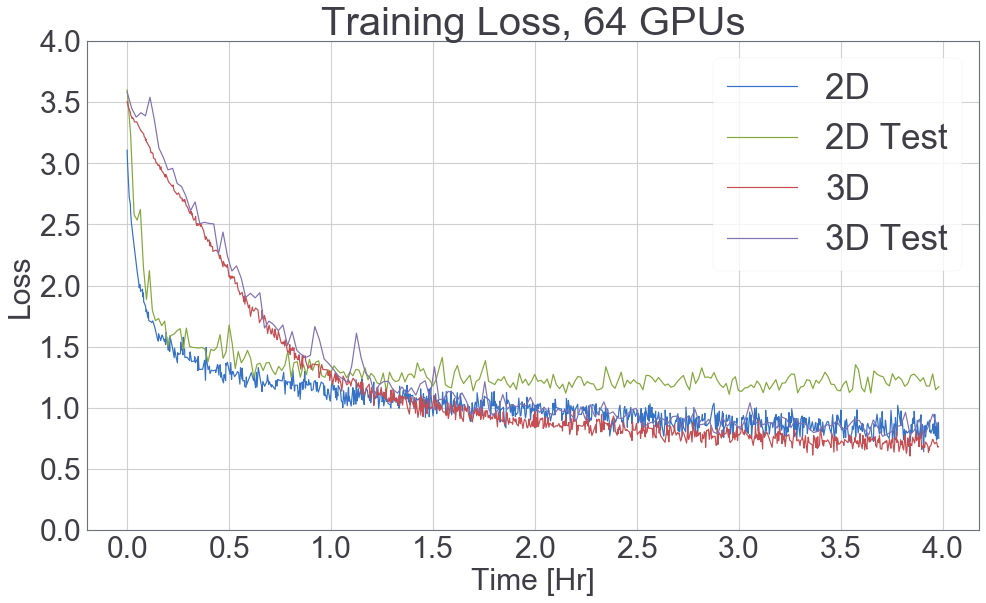

In [341]:
fig = plt.figure(figsize=(16, 9))

plt.plot(loss_2d['Time'], loss_2d['Value'], label="2D")
plt.plot(loss_2d_test['Time'], loss_2d_test['Value'], label="2D Test")
plt.plot(loss_3d['Time'], loss_3d['Value'], label="3D")
plt.plot(loss_3d_test['Time'], loss_3d_test['Value'], label="3D Test")

ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
# ax.set_yscale('log')

plt.ylabel("Loss",fontsize=30)
plt.xlabel("Time [Hr]",fontsize=30)
plt.legend(fontsize=35)

plt.title("Training Loss, 64 GPUs", fontsize=40)

plt.ylim([0, 4])
plt.show()

In [343]:
60*1e5 / (3600*4)

416.6666666666667